In [22]:
from function import *
import numpy as np
import networkx as nx
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Using Random Data

# Number of data
N = 100000
# Number of features
d = 2
# Control precision bit of the output 
precision = 2
# Size of the QUBO matrix
dim = d * (2 * precision)
# Degree of the polynomial regression
degree = 2

# Generate Random Data
X = np.random.rand(N, d)
Y = np.random.rand(N)

# Train-Test data splitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# If you want to perform polynomial regression
# X_train, d, dim = polynomialForm(X_train, d, dim, precision, degree)
# X_test, _, _ = polynomialForm(X_test, d, dim, precision, degree) 

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(d, dim)

(80000, 2)
(20000, 2)
(80000,)
(20000,)
2 8


In [24]:
XtX = np.matmul(X_train.T, X_train) # Covariance matrix
XtY = np.matmul(X_train.T, Y_train) # Relation between Features and Y

print(XtX)
print(XtY)

[[26656.0340769  20000.52574724]
 [20000.52574724 26668.46665763]]
[20010.34997548 20025.77974818]


In [25]:
# The matrix where we add the objective and the constraint (QUBO matrix)
Q = defaultdict(int)

print(Q)

defaultdict(<class 'int'>, {})


In [ ]:
generateQuboMatrix_neal(XtX, XtY, precision, Q, d)

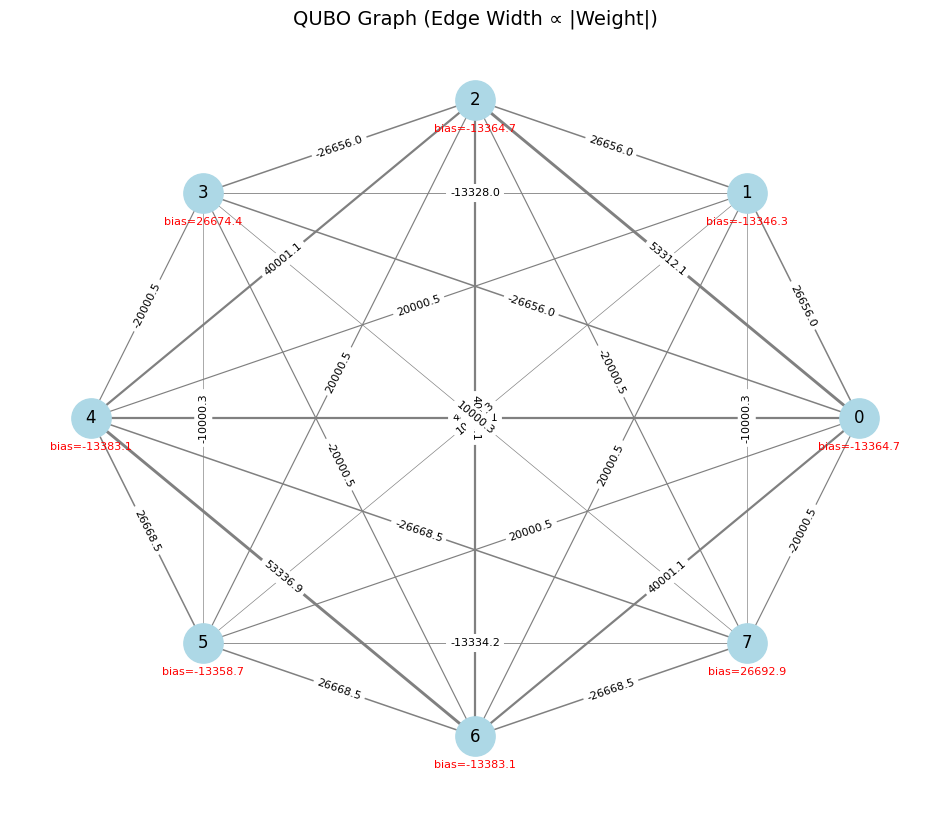

In [27]:
# Initialize the graph and add all nodes first
G = nx.Graph()
nodes = set()
for (i, j) in Q.keys():
    nodes.add(i)
    nodes.add(j)
G.add_nodes_from(nodes)

# Now add edges and node attributes
for (i, j), weight in Q.items():
    if weight != 0 and i <= j:  # Avoid duplicates and zero-weights
        if i == j:
            G.nodes[i]['bias'] = weight  # Now safe because node exists
        else:
            G.add_edge(i, j, weight=weight)

# Visualization
plt.figure(figsize=(12, 10))
pos = nx.circular_layout(G)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=12)

# Scale edge widths by absolute weight
max_weight = max(abs(d['weight']) for _, _, d in G.edges(data=True))
edge_widths = [0.1 + 2 * abs(G[u][v]['weight']) / max_weight for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')

# Add edge labels (rounded)
edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Add node biases
for node, (x, y) in pos.items():
    bias = G.nodes[node].get('bias', 0)
    plt.text(x, y-0.1, f"bias={bias:.1f}", ha='center', fontsize=8, color='red')

plt.title("QUBO Graph (Edge Width ∝ |Weight|)", fontsize=14)
plt.axis('off')
plt.show()

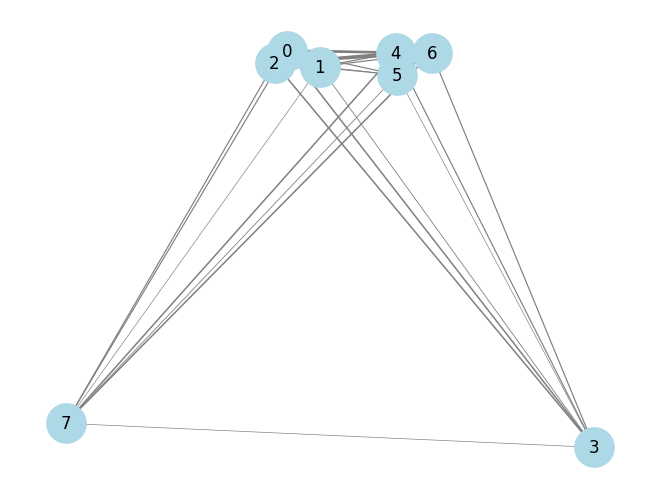

In [28]:
pos = nx.spring_layout(G, k=0.5, weight='weight', iterations=100)
nx.draw(G, pos, with_labels=True, 
       node_color='lightblue', node_size=800,
       width=[0.1 + 2*abs(G[u][v]['weight'])/max_weight for u,v in G.edges()],
       edge_color='gray')

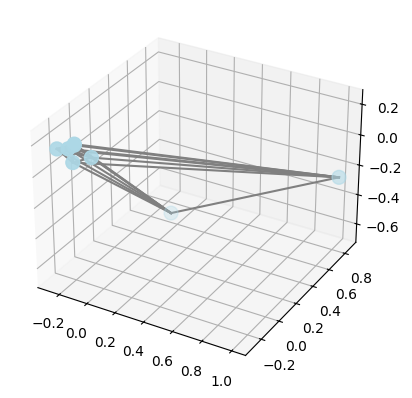

In [29]:
from mpl_toolkits.mplot3d import Axes3D

pos = nx.spring_layout(G, dim=3, weight='weight')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for u, v in G.edges():
    ax.plot([pos[u][0], pos[v][0]], 
            [pos[u][1], pos[v][1]], 
            [pos[u][2], pos[v][2]], 
            'gray')
ax.scatter(*np.array(list(pos.values())).T, s=100, c='lightblue')
plt.show()

In [30]:
# Assuming Q is a dictionary like {(i, j): weight, ...}
G_qubo = nx.Graph()
for (i, j), weight in Q.items():
    if weight != 0:
        G_qubo.add_edge(i, j, weight=weight)  # Store weight as an edge attribute

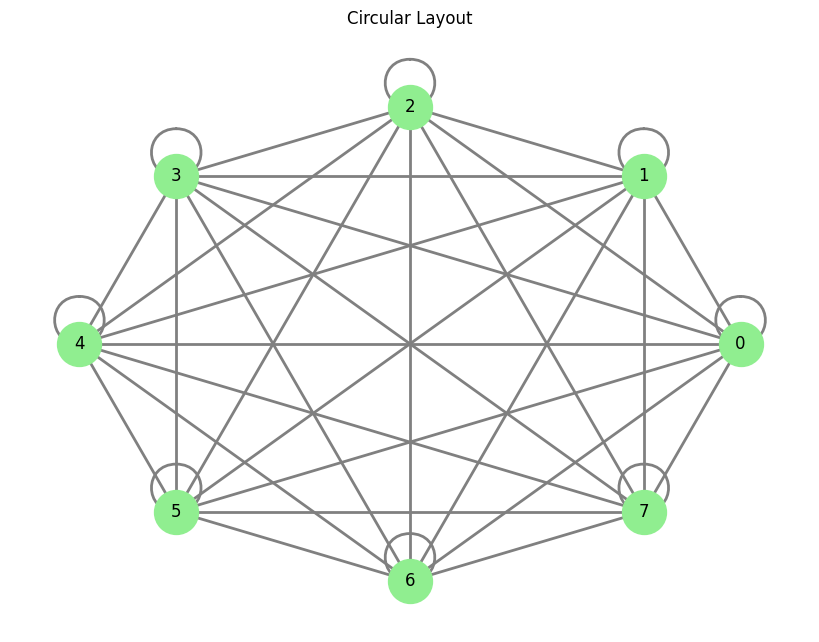

In [31]:
G_qubo = nx.Graph()
for (i, j), weight in Q.items():
    if weight != 0:
        G_qubo.add_edge(i, j)

plt.figure(figsize=(8, 6))
nx.draw_circular(G_qubo, with_labels=True, node_color='lightgreen', 
                 node_size=1000, edge_color='gray', width=2, font_size=12)
plt.title("Circular Layout")
plt.show()

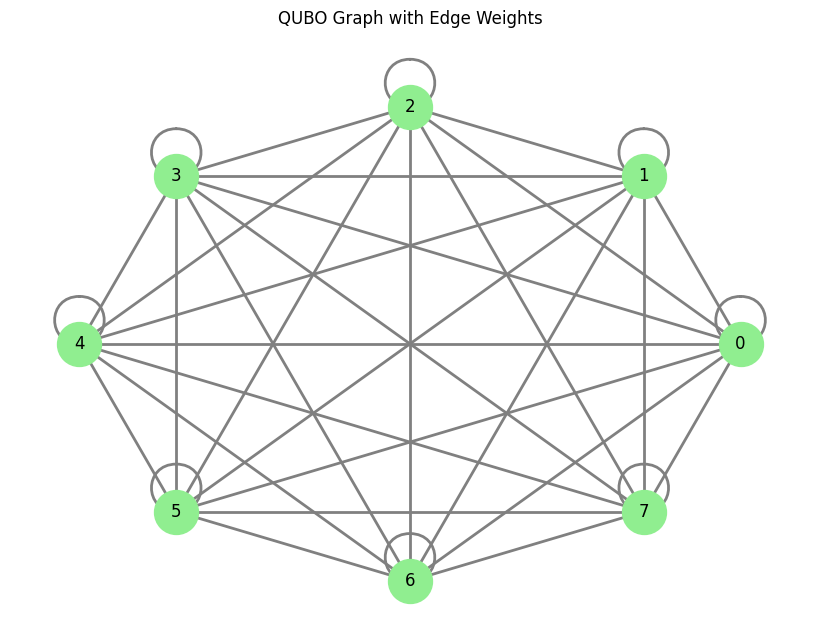

In [32]:
plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G_qubo)  # Get node positions

# Draw the graph
nx.draw(G_qubo, pos, with_labels=True, node_color='lightgreen', 
        node_size=1000, edge_color='gray', width=2, font_size=12)

# Add edge weights as labels
edge_labels = nx.get_edge_attributes(G_qubo, 'weight')  # Extract weights
nx.draw_networkx_edge_labels(G_qubo, pos, edge_labels=edge_labels, font_size=10)

plt.title("QUBO Graph with Edge Weights")
plt.show()

In [33]:
k = 3  # Each variable connects to only 3 others
Q_sparse = defaultdict(int)

for i in set(k for (k, _) in Q.keys()):
    # Get all couplings for variable i
    couplings = [(j, abs(Q[(i, j)])) for (i2, j), w in Q.items() if i2 == i and i != j]
    # Sort by strength and keep top k
    couplings_sorted = sorted(couplings, key=lambda x: x[1], reverse=True)[:k]
    for j, _ in couplings_sorted:
        Q_sparse[(i, j)] = Q[(i, j)]
        Q_sparse[(j, i)] = Q[(j, i)]  # Symmetric

In [34]:
G_sparse = nx.Graph()
for (i, j), weight in Q_sparse.items():
    if i != j and weight != 0:  # Skip diagonal and zero-weight edges
        G_sparse.add_edge(i, j)

print(f"Sparse graph edges: {G_sparse.number_of_edges()}")

Sparse graph edges: 18


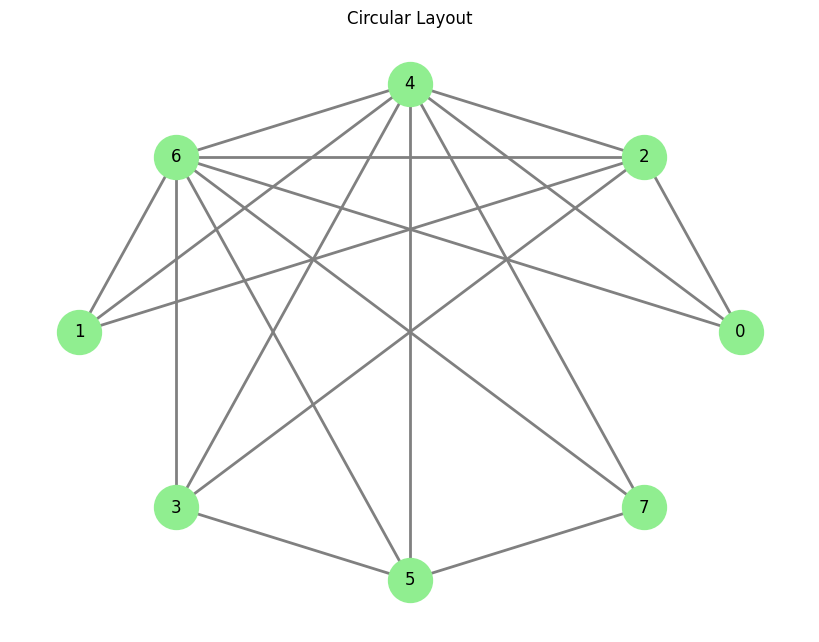

In [35]:
plt.figure(figsize=(8, 6))
nx.draw_circular(G_sparse, with_labels=True, node_color='lightgreen', 
                 node_size=1000, edge_color='gray', width=2, font_size=12)
plt.title("Circular Layout")
plt.show()

In [36]:
print(Q_sparse)

defaultdict(<class 'int'>, {(0, 2): 53312.06815379819, (2, 0): 0, (0, 4): 40001.05149448647, (4, 0): 0, (0, 6): 40001.05149448647, (6, 0): 0, (1, 2): 26656.034076899094, (2, 1): 0, (1, 4): 20000.525747243235, (4, 1): 0, (1, 6): 20000.525747243235, (6, 1): 0, (2, 4): 40001.05149448647, (4, 2): 0, (2, 6): 40001.05149448647, (6, 2): 0, (2, 3): -26656.034076899094, (3, 2): 0, (3, 4): -20000.525747243235, (4, 3): 0, (3, 6): -20000.525747243235, (6, 3): 0, (3, 5): -10000.262873621617, (5, 3): 0, (4, 6): 53336.93331525238, (6, 4): 0, (4, 5): 26668.46665762619, (5, 4): 0, (4, 7): -26668.46665762619, (7, 4): 0, (5, 6): 26668.46665762619, (6, 5): 0, (5, 7): -13334.233328813096, (7, 5): 0, (6, 7): -26668.46665762619, (7, 6): 0})


### Neal Simulated Annealing

In [37]:
# sampleset = sampling(Q)
sampleset = sampling(Q_sparse)
distributions_neal, weights_neal = solve_neal(sampleset, dim, precision, d)

print(weights_neal)

[-0.5  0.5]


In [38]:
Y_train_pred_neal = np.dot(X_train, weights_neal)
Y_test_pred_neal = np.dot(X_test, weights_neal)

# Evaluate on training data
train_mse_neal = mean_squared_error(Y_train, Y_train_pred_neal)
train_mae_neal = mean_absolute_error(Y_train, Y_train_pred_neal)
train_r2_neal = r2_score(Y_train, Y_train_pred_neal)

# Evaluate on test data
test_mse_neal = mean_squared_error(Y_test, Y_test_pred_neal)
test_mae_neal = mean_absolute_error(Y_test, Y_test_pred_neal)
test_r2_neal = r2_score(Y_test, Y_test_pred_neal)

# Print the metrics
print("Neal Training Evaluation:")
print(f"MSE: {train_mse_neal:.5f}, MAE: {train_mae_neal:.5f}, R²: {train_r2_neal:.5f}")

print("\nNeal Testing Evaluation:")
print(f"MSE: {test_mse_neal:.5f}, MAE: {test_mae_neal:.5f}, R²: {test_r2_neal:.5f}")

Neal Training Evaluation:
MSE: 0.37551, MAE: 0.52138, R²: -3.48266

Neal Testing Evaluation:
MSE: 0.37657, MAE: 0.52230, R²: -3.49958


### Fixstar Amplify Simulated Annealing

In [39]:
# distributions_fixstar, weights_fixstar = solve_fixstar(Q, dim, precis=ion, d)
distributions_fixstar, weights_fixstar = solve_fixstar(Q_sparse, dim, precision, d)


print(weights_fixstar)

[0.5 0. ]


In [40]:
Y_train_pred_fixstar = np.dot(X_train, weights_fixstar)
Y_test_pred_fixstar = np.dot(X_test, weights_fixstar)

# Evaluate on training data
train_mse_fixstar = mean_squared_error(Y_train, Y_train_pred_fixstar)
train_mae_fixstar = mean_absolute_error(Y_train, Y_train_pred_fixstar)
train_r2_fixstar = r2_score(Y_train, Y_train_pred_fixstar) 

# Evaluate on test data
test_mse_fixstar = mean_squared_error(Y_test, Y_test_pred_fixstar)
test_mae_fixstar = mean_absolute_error(Y_test, Y_test_pred_fixstar)
test_r2_fixstar = r2_score(Y_test, Y_test_pred_fixstar)

# Print the metrics
print("Fixstar Training Evaluation:")
print(f"MSE: {train_mse_fixstar:.5f}, MAE: {train_mae_fixstar:.5f}, R²: {train_r2_fixstar:.5f}")    

print("\nFixstar Testing Evaluation:")
print(f"MSE: {test_mse_fixstar:.5f}, MAE: {test_mae_fixstar:.5f}, R²: {test_r2_fixstar:.5f}")    

Fixstar Training Evaluation:
MSE: 0.16724, MAE: 0.33397, R²: -0.99642

Fixstar Testing Evaluation:
MSE: 0.16961, MAE: 0.33723, R²: -1.02662


### Scikit Learn (Tradisional way)

In [41]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

start_time = time.time() 

clf = LinearRegression()
clf.fit(X_train, Y_train)
print("Coefficients:", clf.coef_)

Y_train_pred_sklearn = clf.predict(X_train)
Y_test_pred_sklearn = clf.predict(X_test)

# Evaluate on training data
train_mse_sklearn = mean_squared_error(Y_train, Y_train_pred_sklearn)
train_mae_sklearn = mean_absolute_error(Y_train, Y_train_pred_sklearn)
train_r2_sklearn = r2_score(Y_train, Y_train_pred_sklearn) 

# Evaluate on test data
test_mse_sklearn = mean_squared_error(Y_test, Y_test_pred_sklearn)
test_mae_sklearn = mean_absolute_error(Y_test, Y_test_pred_sklearn)
test_r2_sklearn = r2_score(Y_test, Y_test_pred_sklearn)

end_time = time.time()  
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.5f} seconds\n")

# Print the metrics
print("Fixstar Training Evaluation:")
print(f"MSE: {train_mse_sklearn:.5f}, MAE: {train_mae_sklearn:.5f}, R²: {train_r2_sklearn:.5f}")    

print("\nFixstar Testing Evaluation:")
print(f"MSE: {test_mse_sklearn:.5f}, MAE: {test_mae_sklearn:.5f}, R²: {test_r2_sklearn:.5f}")  

Coefficients: [0.00098325 0.00072268]
Execution time: 0.02229 seconds

Fixstar Training Evaluation:
MSE: 0.08377, MAE: 0.25061, R²: 0.00000

Fixstar Testing Evaluation:
MSE: 0.08370, MAE: 0.25101, R²: -0.00012


### Final Evaluation

In [ ]:
data = {
    "Model": ["Neal", "Neal", "Fixstar", "Fixstar", "Sklearn", "Sklearn"],
    "Dataset": ["Train", "Test", "Train", "Test", "Train", "Test"],
    "MSE": [
        train_mse_neal, test_mse_neal,
        train_mse_fixstar, test_mse_fixstar,
        train_mse_sklearn, test_mse_sklearn
    ],
    "MAE": [
        train_mae_neal, test_mae_neal,
        train_mae_fixstar, test_mae_fixstar,
        train_mae_sklearn, test_mae_sklearn
    ],
    "R2 Score": [
        train_r2_neal, test_r2_neal,
        train_r2_fixstar, test_r2_fixstar,
        train_r2_sklearn, test_r2_sklearn
    ]
}

df_eval = pd.DataFrame(data)
df_eval

,Model,Dataset,MSE,MAE,R2 Score
0,Neal,Train,0.375512,0.521384,-3.482661
1,Neal,Test,0.376565,0.522298,-3.499577
2,Fixstar,Train,0.167239,0.333966,-0.996417
3,Fixstar,Test,0.169606,0.337226,-1.026618
4,Sklearn,Train,0.083770,0.250612,0.000001
5,Sklearn,Test,0.083699,0.251015,-0.000117


: 